In [2]:
conda install pytorch torchvision -c pytorch

Solving environment: done

## Package Plan ##

  environment location: /Users/maxhager/opt/anaconda3

  added / updated specs:
    - pytorch
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.3               |   py38hecd8cb5_0         2.9 MB
    ffmpeg-4.3                 |       h0a44026_0        10.1 MB  pytorch
    gnutls-3.6.15              |       hed9c0bf_0         974 KB
    lame-3.100                 |       h1de35cc_0         316 KB
    libidn2-2.3.2              |       h9ed2024_0          85 KB
    libtasn1-4.16.0            |       h9ed2024_0          53 KB
    libunistring-0.9.10        |       h9ed2024_0         519 KB
    nettle-3.7.3               |       h230ac6f_1         380 KB
    openh264-2.1.0             |       hd9629dc_0         635 KB
    pytorch-1.10.0             |          py3.8_0        97.8 MB  pytorch
    torchvision-0.11.1     

In [2]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [25]:
import torch #core package of Torch
import torch.nn as nn #nn is used for building neural networks (makes sense - nested functions..
import torch.nn.functional as F #contains all teh functions in the libray

from sklearn.model_selection import train_test_split
import scikitplot as skplt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [26]:
#read data 
train = pd.read_csv("/Users/maxhager/Jupyter-Notebook-fun/Kaggle/digit-recognizer/train.csv")
test = pd.read_csv("/Users/maxhager/Jupyter-Notebook-fun/Kaggle/digit-recognizer/test.csv")

#checking data
print("shape:", train.shape) #42k rows with each 28x28 integer values between 0-255 (darkness or lightness (greyscale)) - first integer is the digit
print("shape:", test.shape) #doesnt contain the digit integer

shape: (42000, 785)
shape: (28000, 784)


In [27]:
print(train)

       label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0       0   
41997      7       0       0       0       0       0       0       0       0   
41998      6       0       0       0       0       0       0       0       0   
41999      9       0       0       0       0       0       0       0       0   

       pixel8  ...  pixel774  pixel775 

In [28]:
train_all = train.iloc[:,1:] #features without label (just the 28x28 pixels per row)
train_all_label = train["label"] #labels

train_all_numpy = train_all.to_numpy()
train_all_label_numpy = train_all_label.to_numpy()
test_numpy = test.to_numpy()

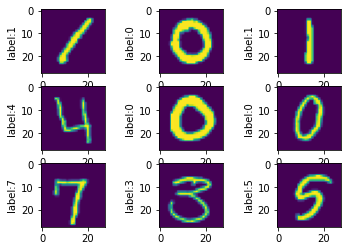

In [29]:
#showing some images (reconverting the range of integers into images - beautiful computers)
def plot_img(data, label):
    fig, axs = plt.subplots(3,3)
    k = 0
    for i in range(3):
        for j in range(3):
            axs[i, j].imshow(data[k].astype("uint8").reshape(28, 28)) #plot image
            axs[i, j].set_ylabel("label:" + str(label[k].item())) #print label
            k += 1
plot_img(train_all_numpy, train_all_label_numpy)

In [30]:
#check differences in label prediction with different amount of test size  (0.2, 0.3)
train, validation, train_label, validation_label = train_test_split(train_all_numpy, train_all_label_numpy, test_size=0.3)

print(train.shape)
print(train_label.shape)
print(validation.shape)
print(validation_label.shape)

(29400, 784)
(29400,)
(12600, 784)
(12600,)


In [31]:
#for what needed?
train_all_tensor = torch.as_tensor(train_all_numpy).type(torch.FloatTensor)
train_all_label_tensor = torch.as_tensor(train_all_label_numpy)
test_tensor = torch.as_tensor(test_numpy).type(torch.FloatTensor)

train_tensor = torch.as_tensor(train).type(torch.FloatTensor)
train_label = torch.as_tensor(train_label)

validation_tensor = torch.as_tensor(validation).type(torch.FloatTensor)
validation_label = torch.as_tensor(validation_label)

In [40]:
class FNet(nn.Module):
    def __init__(self):
        super(FNet, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=600)
        self.fc2 = nn.Linear(in_features=600, out_features=500)
        self.fc3 = nn.Linear(in_features=500, out_features=250)
        self.fc4 = nn.Linear(in_features=250, out_features=10)
        
    #relu for elements in first layer
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [41]:
def get_accuracy(predictions, true_labels):
    _, predicted = torch.max(predictions, 1)
    corrects = (predicted == true_labels).sum()
    accuracy = 100.0 * corrects/len(true_labels)
    return accuracy.item()

In [42]:
def training (dataloader, epochs, model, criterion, optimizer):

    train_accuracies, train_losses = [], []
    
    # set the train mode
    model.train()
    
    # loop over training dataset multiple times
    for epoch in range(epochs):        

        train_loss = 0 
        train_accuracy = 0
        num_batch = 0
        
        # iterate over all batches
        for data, labels in dataloader:
            
            # zero the parameters gradient to not accumulate gradients from previous iteration
            optimizer.zero_grad()
            
            # put data into the model
            predictions = net(data)
            
            # calculate loss
            loss = criterion(predictions, labels)
            
            # calculate accuracy
            accuracy = get_accuracy(predictions, labels)
            
            # compute gradients
            loss.backward()
            
            # change the weights
            optimizer.step()
            
            num_batch += 1
            train_loss += loss.item()
            train_accuracy += accuracy
    
        epoch_accuracy = train_accuracy/num_batch
        epoch_loss = train_loss/num_batch        
        train_accuracies.append(epoch_accuracy)
        train_losses.append(epoch_loss)
        
        print("Epoch: {}/{} ".format(epoch + 1, epochs),
              "Training Loss: {:.4f} ".format(epoch_loss),
              "Training accuracy: {:.4f}".format(epoch_accuracy))
    
    return train_accuracies, train_losses
    

In [43]:
torch.manual_seed(0)                                      # set seed to make results reproducible

batch_size = 128                                          # Set the batch_size
train_dataset = torch.utils.data.TensorDataset(train_tensor, train_label)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)


epochs = 40                                               # set number of epohs

net = FNet()                                              # initialize network
criterion = nn.CrossEntropyLoss()                         # set criterion
optimizer = torch.optim.Adam(net.parameters(), lr = 3e-4) # set optimizer

                                                          # start training process
train_accuracies, train_losses = training(trainloader, epochs, net, criterion, optimizer)

Epoch: 1/40  Training Loss: 0.3113  Training accuracy: 90.9366
Epoch: 2/40  Training Loss: 0.0951  Training accuracy: 97.0334
Epoch: 3/40  Training Loss: 0.0527  Training accuracy: 98.2797
Epoch: 4/40  Training Loss: 0.0326  Training accuracy: 98.9779
Epoch: 5/40  Training Loss: 0.0338  Training accuracy: 98.8436
Epoch: 6/40  Training Loss: 0.0238  Training accuracy: 99.2154
Epoch: 7/40  Training Loss: 0.0205  Training accuracy: 99.3173
Epoch: 8/40  Training Loss: 0.0300  Training accuracy: 98.9896
Epoch: 9/40  Training Loss: 0.0276  Training accuracy: 99.0304
Epoch: 10/40  Training Loss: 0.0187  Training accuracy: 99.3988
Epoch: 11/40  Training Loss: 0.0122  Training accuracy: 99.6501
Epoch: 12/40  Training Loss: 0.0140  Training accuracy: 99.5516
Epoch: 13/40  Training Loss: 0.0185  Training accuracy: 99.4124
Epoch: 14/40  Training Loss: 0.0206  Training accuracy: 99.3410
Epoch: 15/40  Training Loss: 0.0177  Training accuracy: 99.4429
Epoch: 16/40  Training Loss: 0.0127  Training acc

In [44]:
# set net in test (evaluation) mode
net.eval()    
# get predictions
val_predictions = net(validation_tensor)
val_loss = criterion(val_predictions, validation_label)
val_accurasy = get_accuracy(val_predictions, validation_label)
 
print("Loss: ", str(val_loss.item()), "Accuracy: ", str(val_accurasy))

# to get class with the maximum score as prediction
_, val_predicted = torch.max(val_predictions.data,1) 

Loss:  0.21346737444400787 Accuracy:  97.0793685913086


In [45]:
#train all
torch.manual_seed(0)                                      # set seed to make results reproducible

batch_size = 128                                          # Set the batch_size
train_all_dataset = torch.utils.data.TensorDataset(train_all_tensor, train_all_label_tensor)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

epochs = 40                                               # set number of epohs

net = FNet()                                              # initialize network
criterion = nn.CrossEntropyLoss()                         # set criterion
optimizer = torch.optim.Adam(net.parameters(), lr = 3e-4) # set optimizer

                                                          # start training process
train_accuracies, train_losses = training(trainloader, epochs, net, criterion, optimizer)

Epoch: 1/40  Training Loss: 0.3113  Training accuracy: 90.9366
Epoch: 2/40  Training Loss: 0.0951  Training accuracy: 97.0334
Epoch: 3/40  Training Loss: 0.0527  Training accuracy: 98.2797
Epoch: 4/40  Training Loss: 0.0326  Training accuracy: 98.9779
Epoch: 5/40  Training Loss: 0.0338  Training accuracy: 98.8436
Epoch: 6/40  Training Loss: 0.0238  Training accuracy: 99.2154
Epoch: 7/40  Training Loss: 0.0205  Training accuracy: 99.3173
Epoch: 8/40  Training Loss: 0.0300  Training accuracy: 98.9896
Epoch: 9/40  Training Loss: 0.0276  Training accuracy: 99.0304
Epoch: 10/40  Training Loss: 0.0187  Training accuracy: 99.3988
Epoch: 11/40  Training Loss: 0.0122  Training accuracy: 99.6501
Epoch: 12/40  Training Loss: 0.0140  Training accuracy: 99.5516
Epoch: 13/40  Training Loss: 0.0185  Training accuracy: 99.4124
Epoch: 14/40  Training Loss: 0.0206  Training accuracy: 99.3410
Epoch: 15/40  Training Loss: 0.0177  Training accuracy: 99.4429
Epoch: 16/40  Training Loss: 0.0127  Training acc

In [46]:
# set net in test (evaluation) mode
net.eval()  

# get predictions for test data
test_predictions = net(test_tensor)

# to get class with the maximum score as prediction
_, test_predicted = torch.max(test_predictions.data,1)

# Save results in the required format
output = pd.DataFrame({'ImageId': test.index + 1,
                       'Label': test_predicted})
output.to_csv('submission.csv', index=False)
output.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
